Import librairies

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Import and plot dataset

In [2]:
from sklearn import datasets
digits = datasets.load_digits()
print(digits.data.shape)
print(digits.target)

(1797, 64)
[0 1 2 ... 8 9 8]


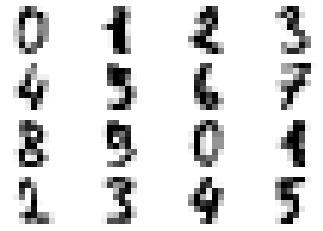

In [3]:
# Plot 16 first elements of dataset.
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    ax.imshow(digits.data[i,:].reshape((8,8)), cmap='Greys')
    ax.set_axis_off()

Split dataset and check if it is balanced

In [4]:
from sklearn.model_selection import train_test_split
data_train, data_test, label_train, label_test = train_test_split(digits.data, digits.target, 
                                                                    test_size=0.3, random_state=84)

Text(0.5, 0, 'train labels')

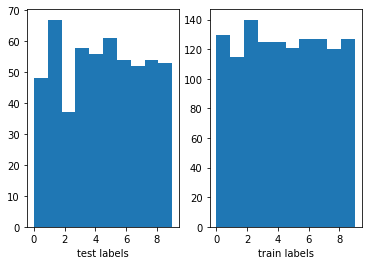

In [5]:
plt.subplot(1, 2, 1)
plt.hist(label_test)
plt.xlabel('test labels')
plt.subplot(1, 2, 2)
plt.hist(label_train)
plt.xlabel('train labels')

Clearly, here it is not balanced which can affect the NN performance. Let's use stratify to split the dataset into balanced train/test sets

In [6]:
from sklearn.model_selection import train_test_split
data_train, data_test, label_train, label_test = train_test_split(digits.data, digits.target, 
                                                                    test_size=0.3, random_state=84, stratify=digits.target)

Text(0.5, 0, 'train labels')

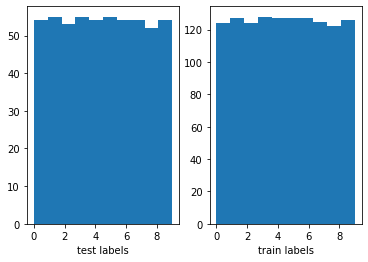

In [7]:
plt.subplot(1, 2, 1)
plt.hist(label_test)
plt.xlabel('test labels')
plt.subplot(1, 2, 2)
plt.hist(label_train)
plt.xlabel('train labels')

## Create first KNN classifieur

In [8]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbors = 5
knnc = KNeighborsClassifier(n_neighbors=n_neighbors)
knnc.fit(X=data_train,
        y=label_train)
accuracy = knnc.score(X = data_test, 
                      y=label_test)
print('The 5-NNC has a performance of {}'.format(accuracy))



The 5-NNC has a performance of 0.9833333333333333


Let's try a l2 Logistic Regression with regularisatio param $\frac{1}{C} = \frac{1}{2}$. and compare the performances

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

C = 2
penalty='l2'
lreg = LogisticRegression(penalty=penalty, C=C, max_iter=200)
pip = Pipeline([('scaler', StandardScaler()), ('lreg', lreg)])

pip.fit(X=data_train,
       y=label_train)
accuracy = pip.score(X = data_test, 
                      y=label_test)
print('The logistic regression has a performance of {}'.format(accuracy))


The logistic regression has a performance of 0.9648148148148148


Let's display the good and bad classification of the 5-NNC

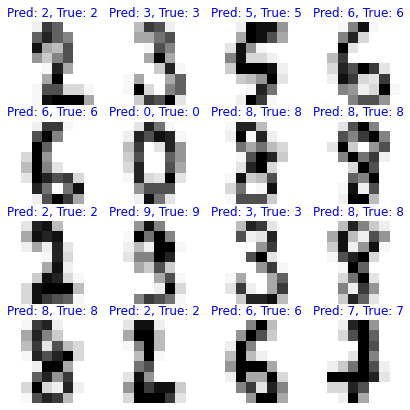

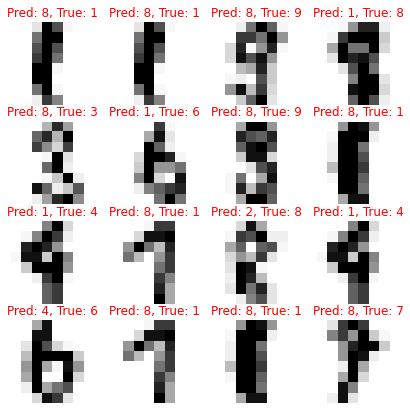

In [10]:
np.random.seed(84)
preds = pip.predict(X=data_test)
success = np.array(preds) == np.array(label_test)   
np.random.seed(84)

# Here are some of the successful predictions:
data_s, pred_s, label_s =data_test[success,:], preds[success], label_test[success]
sample = np.random.choice(len(pred_s), size=16)
color = {True:'b', False:'r'}
plt.figure(figsize=(7, 7))
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    pred, ground_truth = pred_s[sample][i], label_s[sample][i]
    ax.imshow(data_s[sample,:][i,:].reshape((8,8)), cmap='Greys')
    ax.set_title('Pred: {}, True: {}'.format(pred, ground_truth), color='b')
    ax.set_axis_off()

# And here some failure cases:
data_f, pred_f, label_f =data_test[~success,:], preds[~success], label_test[~success]
sample = np.random.choice(len(pred_f),size=16)
plt.figure(figsize=(7, 7))
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    pred, ground_truth = pred_f[sample][i], label_f[sample][i]
    ax.imshow(data_f[sample,:][i,:].reshape((8,8)), cmap='Greys')
    ax.set_title('Pred: {}, True: {}'.format(pred, ground_truth), color='r')
    ax.set_axis_off()

## Evaluate the performance of a model

Let's look at accuracy and f1

In [11]:
from sklearn import metrics
acc = metrics.accuracy_score(y_true=label_test, y_pred=preds)
f1_weighted = metrics.f1_score(label_test, preds, average='weighted')
print('Accuracy : {}, f1 : {}'.format(acc, f1_weighted))

Accuracy : 0.9648148148148148, f1 : 0.9650817254659414


Let's display the full report

In [12]:
report = metrics.classification_report(y_true=label_test, y_pred=preds)
print(report)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        54
           1       0.93      0.93      0.93        55
           2       0.98      0.98      0.98        53
           3       0.98      0.98      0.98        55
           4       0.95      0.98      0.96        54
           5       0.98      1.00      0.99        55
           6       1.00      0.94      0.97        54
           7       1.00      0.98      0.99        54
           8       0.86      0.92      0.89        52
           9       0.98      0.93      0.95        54

    accuracy                           0.96       540
   macro avg       0.97      0.96      0.96       540
weighted avg       0.97      0.96      0.97       540



Let's display the confusion matrix

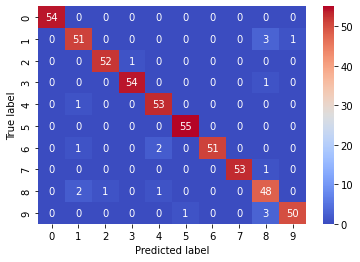

In [13]:
import seaborn as sns
cm = metrics.confusion_matrix(y_true=label_test, y_pred=preds)
ax = sns.heatmap(cm, cmap='coolwarm', annot=cm)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
plt.show()

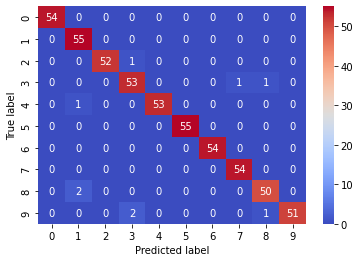

In [14]:
#For the 5-NNC model
preds = knnc.predict(data_test)
cm = metrics.confusion_matrix(y_true=label_test, y_pred=preds)
ax = sns.heatmap(cm, cmap='coolwarm', annot=cm)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
plt.show()

## Selection of the modele

To select a model and the right hyperparameter, we could brutaly do a grid_search to test all hyperparameters. This is sub-optimised and take very long time, we will see later other methods to avoid trying them all (such as Optuna for instance). For now as there is only one hyperparameter, let's plot its influence.

It is also worth remembering that if the dataset is relatively small, the hyperparameter might be overfitted for a given train/test set. To overcome this with a small dataset, one can do a cross validation. 

Write the code to try all hyperparameters with grid_search using cross validation

In [15]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors':np.arange(1, 20, 2)}

cv = GridSearchCV(estimator=KNeighborsClassifier(),
                    param_grid=param_grid,
                    scoring='accuracy',
                    cv=5)
cv.fit(data_train,
      label_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19])},
             scoring='accuracy')

Text(0, 0.5, 'accuracy')

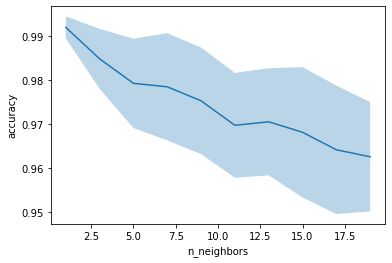

In [16]:
## Plot of the results by hyperparam with cross val
import pandas as pd
res = cv.cv_results_
x = [x['n_neighbors'] for x in res['params']]
y = res['mean_test_score']
stds = res['std_test_score']
sns.lineplot(x=x, y=y)
lower_bound = y - stds
upper_bound = y + stds
plt.fill_between(x, lower_bound, upper_bound, alpha=.3)
plt.xlabel('n_neighbors')
plt.ylabel('accuracy')

Do the same with the logistic regression

In [17]:
from sklearn.model_selection import GridSearchCV
stsc = StandardScaler()
data_train = stsc.fit_transform(data_train)

param_grid = {'C':np.arange(1, 50, 2)/10}
cv = GridSearchCV(estimator=LogisticRegression(penalty='l2', max_iter=300),
                    param_grid=param_grid,
                    scoring='accuracy',
                    cv=5)
cv.fit(data_train,
      label_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=300),
             param_grid={'C': array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5,
       2.7, 2.9, 3.1, 3.3, 3.5, 3.7, 3.9, 4.1, 4.3, 4.5, 4.7, 4.9])},
             scoring='accuracy')

Text(0, 0.5, 'accuracy')

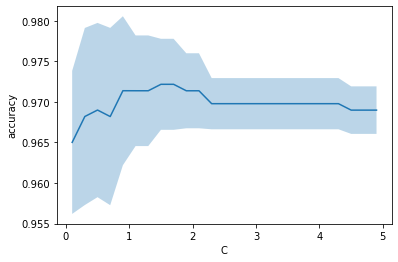

In [18]:
## Plot of the results by hyperparam with cross val
import pandas as pd
res = cv.cv_results_
x = [x['C'] for x in res['params']]
y = res['mean_test_score']
stds = res['std_test_score']
sns.lineplot(x=x, y=y)
lower_bound = y - stds
upper_bound = y + stds
plt.fill_between(x, lower_bound, upper_bound, alpha=.3)
plt.xlabel('C')
plt.ylabel('accuracy')